In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns

#from spectral_normalization import SpectralNorm

### Input

Setting some constant values for the notebook

In [2]:
manualSeed = 230
datafile = "s_configs_Tc_64_2.npy"
batch_size = 64
start_config = 15000
num_configs = 50000
nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0')
#device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

#### Determine your algorithm

In [3]:
Loss_func = "BCE" # "hinge" or "Wasserstein" or "BCE"
optimizer = "Adam" # "RMS", "Adam"
Mz_loss = True # if the magnetization penalty is applied
SNGAN = False # if using the spectral normalization GAN
WGAN = False # if using the Wasserstein-GAN
Gradientpenalty = False # if using the gradient penalty (for W-GAN)
WeightClipping = False # if using the weight clipping (for W-GAN)

### Neural net
#### Generator
We follow the standard DCGAN generator network with one difference in the last layer. After tanh in the last layer, we set all elements larger than 0 to 1, and all elements less than 0 to -1, so the output is the usual Ising spin values. Let's call this procedure stepping because the function resembles a step function :)

In [4]:
# custom weights initialization called on netG and netD
# The weights_init function takes an initialized model as input 
#  and reinitializes all convolutional, convolutional-transpose, and batch normalization layers 
#  to meet this criteria.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Stepping(nn.Module):
    def __init__(self):
        super(Stepping, self).__init__()
        
    def forward(self, x):
        return (x > 0).type_as(x) * 2 - 1

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

#### Spectral Normalization and Discriminator
reference:
1. https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/spectral_normalization.py
2. https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/model.py

In [7]:
from torch.optim.optimizer import Optimizer, required
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [8]:
# Batch normalization is avoided for the critic (discriminator).
if SNGAN and not WGAN:
    
    class Discriminator(nn.Module):   
        def __init__(self, ngpu):
            super(Discriminator, self).__init__()
            self.ngpu = ngpu
            self.main = nn.Sequential(
                # input is (nc) x 64 x 64
                #nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
                SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf) x 32 x 32
                SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
                #nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 16 x 16
                SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
                #nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 8 x 8
                SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
                #nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*8) x 4 x 4
                SpectralNorm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False))
            )

        def forward(self, input):
            return self.main(input)

elif WGAN and not SNGAN:
    
    class Discriminator(nn.Module):
        def __init__(self, ngpu):
            super(Discriminator, self).__init__()
            self.ngpu = ngpu
            self.main = nn.Sequential(
                # input is (nc) x 64 x 64
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf) x 32 x 32
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 16 x 16
                nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 8 x 8
                nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*8) x 4 x 4
                nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
            )

        def forward(self, input):
            return self.main(input)
    
elif not WGAN and not SNGAN:
    
    class Discriminator(nn.Module):
        def __init__(self, ngpu):
            super(Discriminator, self).__init__()
            self.ngpu = ngpu
            self.main = nn.Sequential(
                # input is (nc) x 64 x 64
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf) x 32 x 32
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 16 x 16
                nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 8 x 8
                nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*8) x 4 x 4
                nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )

        def forward(self, input):
            return self.main(input)
    
else: 
    print("WRONG!")
    

### Data

Load data and seed

In [9]:
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

In [10]:
# load data
S_snapshots = np.load(datafile)
print("S_snapshots.shape =", S_snapshots.shape)

# choose data after warming up
#S_snapshots = S_snapshots[start_config:]
#print("S_snapshots.shape =", S_snapshots.shape)

# shuffle data before training
np.random.shuffle(S_snapshots) # shuffle the configurations to eliminate the time evolutional effects
S_snapshots_tensor = torch.tensor(S_snapshots, dtype=torch.double)

S_snapshots.shape = (100000, 1, 64, 64)


Let's visualize the data

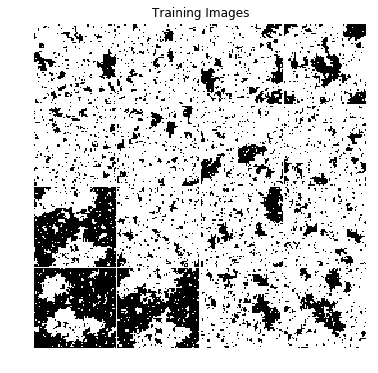

In [11]:
a = torch.tensor(S_snapshots[:16])
b = vutils.make_grid(a, nrow=4, padding=1, normalize=True)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Training Images")
plt.pcolormesh(b[0], cmap='gray_r')
plt.show()

### Training
make data loader

In [12]:
dataloader = torch.utils.data.DataLoader(S_snapshots_tensor[0:num_configs], batch_size=batch_size, shuffle=False)

Initialize generator and discriminator and start training

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [14]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
#netD.apply(weights_init) # weights have been initialized inside the Discriminator function.

Define loss functions and optimizers

In [15]:
# Initialize BCELoss function (not used)
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup RMSprop optimizers or Adam prop for both G and D (Wasserstein GAN)
if optimizer == "RMS":
    optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
    optimizerG = optim.RMSprop(netG.parameters(), lr=lr)
    
elif optimizer == "Adam":
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
else: 
    print("Optimizer is not defined!")

#### Define gradient penalty
reference: https://github.com/EmilienDupont/wgan-gp

In [16]:
def gradient_penalty(real_data, generated_data):
    gp_weight = 10
    batch_size = real_data.size()[0]
    
    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    if (device.type == 'cuda') and (ngpu > 0):
        alpha = alpha.cuda()
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    if (device.type == 'cuda') and (ngpu > 0):
        interpolated = interpolated.cuda()

    
    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).cuda() if ((device.type == 'cuda') and (ngpu > 0)) else torch.ones(
                               prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return gp_weight * ((gradients_norm - 1) ** 2).mean()


### Training Loop

In [17]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
print_freq =100

criterion_mz = nn.MSELoss()

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: Wasserstein loss function
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device) # real data
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        
        # change all configurations with mz < 0 to mz > 0
        sign = torch.sum(real_cpu, (-1,-2,-3))
        sign = torch.sign(sign)
        sign = sign.cpu().numpy().reshape((sign.shape[0],1,1,1))
        s_test = real_cpu.cpu().numpy()
        s_test = sign * s_test
        real_cpu = torch.from_numpy(s_test).to(device)
        
        # real magnetization
        if Mz_loss:
            mz_real = torch.mean(real_cpu, (-1,-2,-3))
        else:
            None
        
        # Forward pass real batch through D
        D_real = netD(real_cpu.float()).view(-1)
        # Calculate loss on all-real batch
        if Loss_func == "Wasserstein":
            errD_real = -torch.mean(D_real)
        elif Loss_func == "hinge":
            errD_real = nn.ReLU()(1.0 - D_real).mean()
        elif Loss_func == "BCE":
            errD_real = criterion(D_real, label)
            errD_real.backward()
        # Calculate gradients for D in backward pass
        # errD_real.backward()
        D_x = D_real.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise) # generated data
        
        # fake magnetization
        if Mz_loss:
            mz_fake = torch.mean(fake, (-1,-2,-3))
        else:
            None
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        D_fake = netD(fake.detach()).view(-1) 
        # Calculate D's loss on the all-fake batch    
        if Loss_func == "Wasserstein":
            errD_fake = torch.mean(D_fake) 
        elif Loss_func == "hinge":
            errD_fake = nn.ReLU()(1.0 + D_fake).mean()
        elif Loss_func == "BCE":
            errD_fake = criterion(D_fake, label)
            errD_fake.backward()
        # Calculate the gradients for this batch
        D_G_z1 = D_fake.mean().item()
        
        # Add the gradients from the all-real and all-fake batches
        # consider gradient penalty
        if Gradientpenalty == True:
            gd_penalty = gradient_penalty(real_cpu.float(), fake.float())
            errD = errD_real + errD_fake + gd_penalty
        else:
            errD = errD_real + errD_fake
        
        # Calculate the gradients for this batch
        if Loss_func == "BCE":
            None
        else:
            errD.backward()
        # Update D
        optimizerD.step()
        
        # weight clipping
        if WeightClipping == True:
            for wclip in netD.parameters():
                wclip.data.clamp_(-0.01, 0.01)
        
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        
        # Calculate G's loss based on this output
        # Calcultae G's loss based on the magnetization by criterion_mz()
        if Mz_loss:
            if Loss_func == "Wasserstein" or Loss_func == "hinge":
                errG = -torch.mean(output) + criterion_mz(mz_real.float().to(device), mz_fake.float().to(device))
            elif Loss_func == "BCE":
                errG = criterion(output, label) + criterion_mz(mz_real.float().to(device), mz_fake.float().to(device))
        else:
            if Loss_func == "Wasserstein" or Loss_func == "hinge":
                errG = -torch.mean(output)
            elif Loss_func == "BCE":
                errG = criterion(output, label)
        
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        if i % print_freq == 0:
            print("G training {}, loss {}, D(G(z)) {}".format(0, errG.item(), D_G_z2))
        
        for j in range(1,1):
            # noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            if Loss_func == "Wasserstein" or Loss_func == "hinge":
                errG = -torch.mean(output)
            elif Loss_func == "BCE":
                errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            print("G training {}, loss {}, D(G(z)) {}".format(j, errG.item(), D_G_z2))

        # Output training stats
        if i % print_freq == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
G training 0, loss 1.565199613571167, D(G(z)) 0.332939088344574
[0/5][0/782]	Loss_D: 1.4451	Loss_G: 1.5652	D(x): 0.5332	D(G(z)): 0.5521 / 0.3329
G training 0, loss 3.562264919281006, D(G(z)) 0.04053448885679245
[0/5][100/782]	Loss_D: 0.7022	Loss_G: 3.5623	D(x): 0.6735	D(G(z)): 0.2172 / 0.0405
G training 0, loss 6.704633712768555, D(G(z)) 0.00184672512114048
[0/5][200/782]	Loss_D: 0.8836	Loss_G: 6.7046	D(x): 0.9465	D(G(z)): 0.5250 / 0.0018
G training 0, loss 6.308389663696289, D(G(z)) 0.002436155453324318
[0/5][300/782]	Loss_D: 0.3247	Loss_G: 6.3084	D(x): 0.8905	D(G(z)): 0.1716 / 0.0024
G training 0, loss 5.569855690002441, D(G(z)) 0.006195698864758015
[0/5][400/782]	Loss_D: 0.1181	Loss_G: 5.5699	D(x): 0.9187	D(G(z)): 0.0271 / 0.0062
G training 0, loss 7.158968448638916, D(G(z)) 0.0011296471348032355
[0/5][500/782]	Loss_D: 0.0286	Loss_G: 7.1590	D(x): 0.9859	D(G(z)): 0.0140 / 0.0011
G training 0, loss 6.242627143859863, D(G(z)) 0.002537922002375126
[0/5][600/782

In [18]:
G_modules_list = list(netG.modules())

#### check output

In [19]:
fake = netG(fixed_noise)

In [20]:
output = netD(fake).view(-1)

In [21]:
step_f = Stepping()

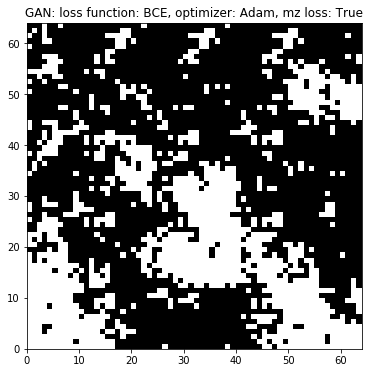

In [33]:
plt.figure(figsize=(6,6))
if SNGAN:
    plt.title("SN-GAN: loss function: {}, optimizer: {}, mz loss: {}".format(Loss_func, optimizer, Mz_loss))
elif WGAN and Gradientpenalty:
    plt.title("W-GAN with GP: loss function: {}, optimizer: {}, mz loss: {}".format(Loss_func, optimizer, Mz_loss))
elif WGAN and WeightClipping:
    plt.title("W-GAN with WC: loss function: {}, optimizer: {}, mz loss: {}".format(Loss_func, optimizer, Mz_loss))
elif not WGAN and not SNGAN:
    plt.title("GAN: loss function: {}, optimizer: {}, mz loss: {}".format(Loss_func, optimizer, Mz_loss))
plt.pcolormesh(step_f(fake[53].detach().cpu()[0]), cmap='binary')
plt.show()



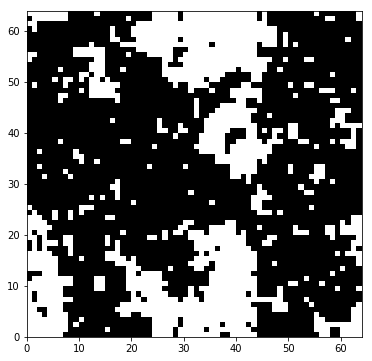

In [78]:
plt.figure(figsize=(6,6))
plt.pcolormesh(-1*data[2][0], cmap='binary')
plt.show()

In [29]:
# generate N_fake fake data
N_fake = 10000
fixed_noise = torch.randn(N_fake, nz, 1, 1)
fakedata = netG.cpu()(fixed_noise)
fakedata = step_f(fakedata)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


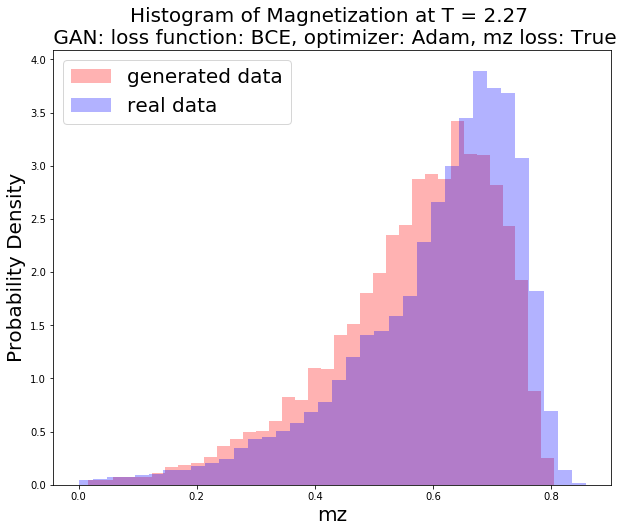

In [30]:
Tmpt =2.27
# matplotlib histogram
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=int(180/5))

fake_mz = abs(torch.mean(fakedata.cpu(), (-1,-2,-3))).detach().numpy()
real_mz = abs(np.mean(S_snapshots, (-1,-2,-3)))

plt.figure(figsize=(10,8))
plt.hist(fake_mz, **kwargs, label='generated data', color = 'r')
plt.hist(real_mz, **kwargs, label ='real data', color = 'b')

# Add labels
plt.legend(loc='upper left',fontsize=20)
if SNGAN:
    plt.title('Histogram of Magnetization at T = {} \n SN-GAN: loss function: {}, optimizer: {}, mz loss: {}'.format(Tmpt, Loss_func, optimizer, Mz_loss),fontsize=20)
elif WGAN and Gradientpenalty:
    plt.title('Histogram of Magnetization at T = {} \n W-GAN with GP: loss function: {}, optimizer: {}, mz loss: {}'.format(Tmpt, Loss_func, optimizer, Mz_loss),fontsize=20)
elif WGAN and WeightClipping:
    plt.title('Histogram of Magnetization at T = {} \n W-GAN with WC: loss function: {}, optimizer: {}, mz loss: {}'.format(Tmpt, Loss_func, optimizer, Mz_loss),fontsize=20)
elif not SNGAN and not WGAN:
    plt.title('Histogram of Magnetization at T = {} \n GAN: loss function: {}, optimizer: {}, mz loss: {}'.format(Tmpt, Loss_func, optimizer, Mz_loss),fontsize=20)

plt.xlabel('mz',fontsize=20)
plt.ylabel('Probability Density',fontsize=20)
plt.show()


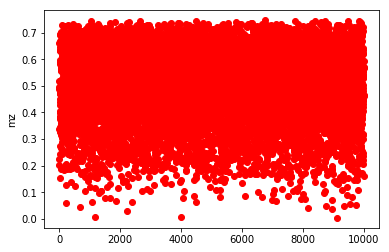

In [42]:
plt.plot(fake_mz,'ro')
plt.xlabel("")
plt.ylabel("mz")
plt.show()

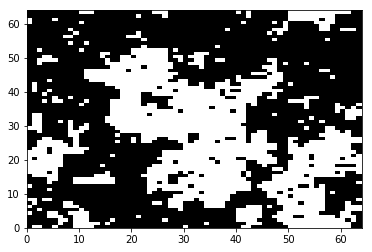

In [62]:
plt.pcolormesh(torch.from_numpy(S_snapshots[5]).reshape((Nx,Ny)), cmap='binary')